### All data but clean

In [328]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

In [329]:
df = pd.read_csv('data/raw_dataset.csv')
df.shape

(4424, 35)

In [330]:
df = df[df["Target"].isin(["Dropout", "Graduate"])].copy()
print("Shape after keeping Dropout/Graduate:", df.shape)

Shape after keeping Dropout/Graduate: (3630, 35)


### Remove Nal first year

In [331]:
first_year_cols = [
    "Curricular units 1st sem (credited)",
    "Curricular units 1st sem (enrolled)",
    "Curricular units 1st sem (evaluations)",
    "Curricular units 1st sem (approved)",
    "Curricular units 1st sem (grade)",
    "Curricular units 1st sem (without evaluations)",
    "Curricular units 2nd sem (credited)",
    "Curricular units 2nd sem (enrolled)",
    "Curricular units 2nd sem (evaluations)",
    "Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (grade)",
    "Curricular units 2nd sem (without evaluations)"
]
df[first_year_cols] = df[first_year_cols].apply(pd.to_numeric, errors="coerce")
mask_all_zero = (df[first_year_cols] == 0).all(axis=1)

df = df[~mask_all_zero].copy()

print("Shape after removing NAL observations:", df.shape)
print("Removed rows:", mask_all_zero.sum())

Shape after removing NAL observations: (3478, 35)
Removed rows: 152


In [332]:
top_5_features = [
    'Tuition fees up to date',
    'Age at enrollment',
    'Course',
    'Scholarship holder',
    'Application mode',
    'Target'
]
cols_to_drop = [c for c in df.columns if c not in top_5_features]
print(f"Dropping academic history columns: {cols_to_drop}")
print(len(cols_to_drop))

Dropping academic history columns: ['Marital status', 'Application order', 'Daytime/evening attendance', 'Previous qualification', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Displaced', 'Educational special needs', 'Debtor', 'Gender', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP']
29


In [333]:
df = df.drop(columns=cols_to_drop).copy()

### Now we have cleand data

In [334]:
print("Cleaned data shape:", df.shape)
print("Target distribution:\n", df["Target"].value_counts())


Cleaned data shape: (3478, 6)
Target distribution:
 Target
Graduate    2134
Dropout     1344
Name: count, dtype: int64


In [335]:
all_feature_cols = [c for c in df.columns if c != "Target"]
categorical_cols = all_feature_cols

In [336]:
for col in categorical_cols:
    df[col] = df[col].astype("category")


In [337]:
df["y"] = (df["Target"] == "Dropout").astype(int)

X = df[all_feature_cols]
y = df["y"]


In [338]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [339]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

In [340]:
log_reg = LogisticRegression(
    max_iter=2000,
    # class_weight="balanced"  # uncomment if dropout is very imbalanced
)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=4,
    random_state=42,
    n_jobs=-1
)

xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

pipe_log = Pipeline([("prep", preprocess), ("model", log_reg)])
pipe_rf  = Pipeline([("prep", preprocess), ("model", rf)])
pipe_xgb = Pipeline([("prep", preprocess), ("model", xgb)])

In [341]:
pipe_log.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)
pipe_xgb.fit(X_train, y_train)

,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



Logistic Regression results
Accuracy: 0.78
AUC: 0.837
Confusion Matrix:
 [[390  37]
 [116 153]]

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.84       427
           1       0.81      0.57      0.67       269

    accuracy                           0.78       696
   macro avg       0.79      0.74      0.75       696
weighted avg       0.78      0.78      0.77       696



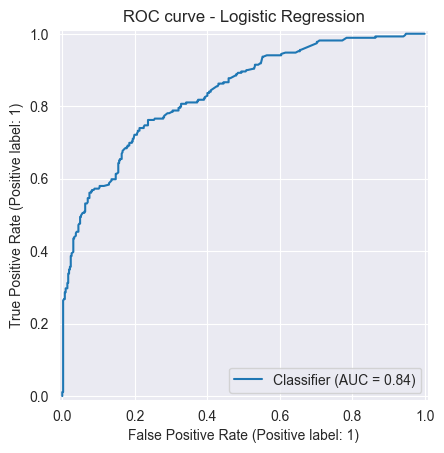


Random Forest results
Accuracy: 0.743
AUC: 0.82
Confusion Matrix:
 [[355  72]
 [107 162]]

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.83      0.80       427
           1       0.69      0.60      0.64       269

    accuracy                           0.74       696
   macro avg       0.73      0.72      0.72       696
weighted avg       0.74      0.74      0.74       696



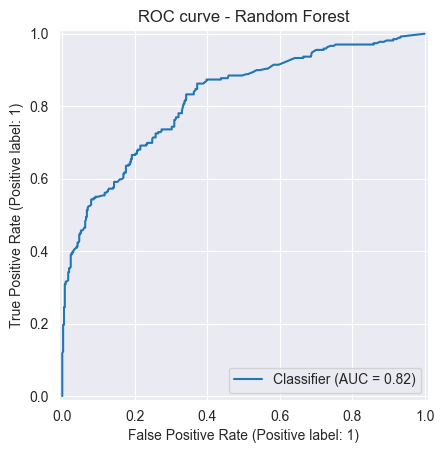


XGBoost results
Accuracy: 0.754
AUC: 0.83
Confusion Matrix:
 [[367  60]
 [111 158]]

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.86      0.81       427
           1       0.72      0.59      0.65       269

    accuracy                           0.75       696
   macro avg       0.75      0.72      0.73       696
weighted avg       0.75      0.75      0.75       696



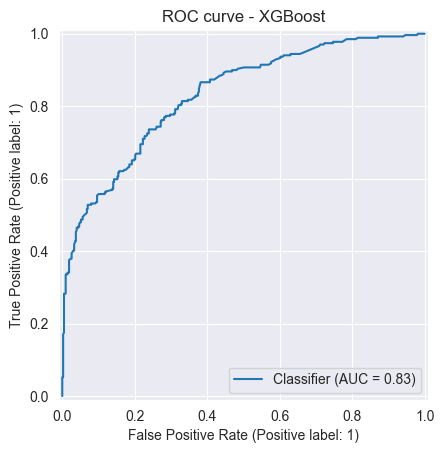

In [342]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

def evaluate(model, name):
    print("\n" + "="*70)
    print(f"{name} results")
    print("="*70)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    print("Accuracy:", round(acc, 3))
    print("AUC:", round(auc, 3))
    print("Confusion Matrix:\n", cm)
    print("\nClassification report:\n", classification_report(y_test, y_pred))

    # optional: ROC curve
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"ROC curve - {name}")
    plt.show()

evaluate(pipe_log, "Logistic Regression")
evaluate(pipe_rf,  "Random Forest")
evaluate(pipe_xgb, "XGBoost")

### feature importance of the XGBoost model

In [343]:
xgb_model = pipe_xgb.named_steps["model"]

In [344]:
# Fit preprocessing on train data if not yet fitted
preprocess.fit(X_train)

ohe = preprocess.named_transformers_["cat"]
encoded_cat_names = list(ohe.get_feature_names_out(categorical_cols))

feature_names = numeric_cols + encoded_cat_names

In [345]:
booster = xgb_model.get_booster()
importance_dict = booster.get_score(importance_type='gain')

In [346]:
importance_df = pd.DataFrame([
    (feature_names[int(k[1:])], v)
    for k, v in importance_dict.items()
], columns=["feature", "gain_importance"])

importance_df = importance_df.sort_values("gain_importance", ascending=False)
print(importance_df.head(20))

                 feature  gain_importance
29             Course_15        38.080742
30             Course_16        25.481026
31             Course_17         6.214075
18              Course_4         5.487823
27             Course_13         3.673408
19              Course_5         3.353660
23              Course_9         3.264867
7     Application mode_8         2.589591
3     Application mode_3         2.466770
20              Course_6         2.358370
21              Course_7         2.146057
22              Course_8         2.047601
12   Application mode_14         2.031007
0      Unemployment rate         1.988868
45  Age at enrollment_27         1.972272
40  Age at enrollment_22         1.817616
51  Age at enrollment_33         1.684169
1     Application mode_1         1.640298
60  Age at enrollment_42         1.606582
16              Course_2         1.556898


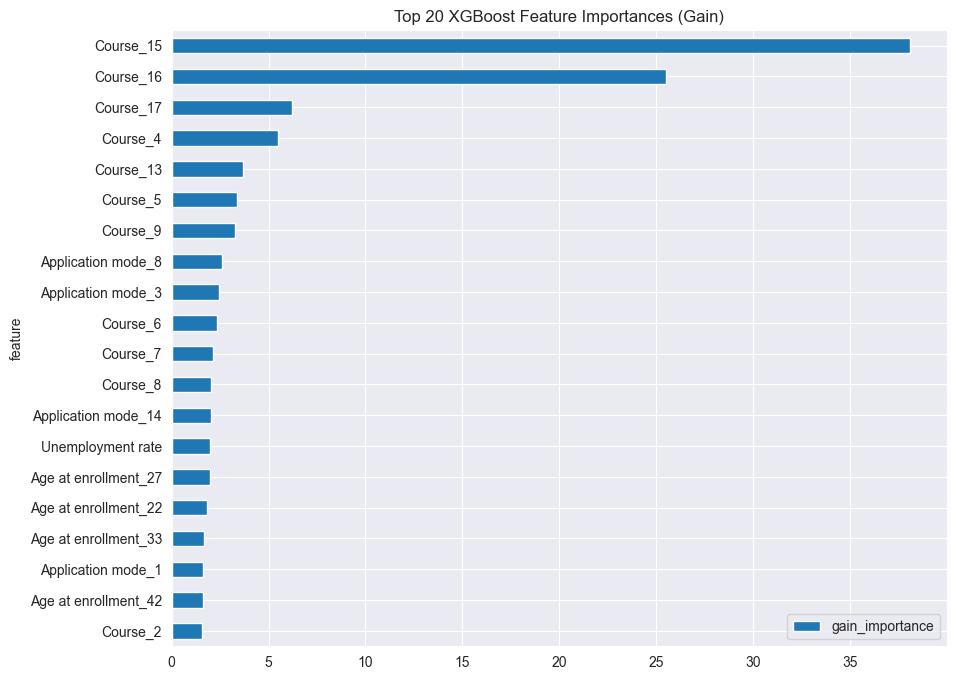

In [347]:
importance_df.head(20).plot(
    x='feature',
    y='gain_importance',
    kind='barh',
    figsize=(10,8)
)
plt.title("Top 20 XGBoost Feature Importances (Gain)")
plt.gca().invert_yaxis()
plt.show()

### Getting importance at the variable level (not each dummy)

In [348]:
# importance_df has columns: ["feature", "gain_importance"]

# base feature name = everything before the last underscore
importance_df["base_feature"] = importance_df["feature"].str.replace(r"_[^_]+$", "", regex=True)

# For numeric features (no underscore at the end) this leaves them as-is.

# Sum gain importance over all dummies of the same original feature
grouped_importance = (
    importance_df
    .groupby("base_feature")["gain_importance"]
    .sum()
    .sort_values(ascending=False)
)

print(grouped_importance.head(20))

base_feature
Course                     101.159061
Age at enrollment           37.873618
Application mode            19.566544
Scholarship holder           2.418778
Unemployment rate            1.988868
Tuition fees up to date      1.213735
Name: gain_importance, dtype: float64


# C-V

In [354]:
from sklearn.model_selection import cross_val_score

model_to_test = rf
#log_reg
#rf
#xgb
scores = cross_val_score(model_to_test, X, y, cv=5, scoring='accuracy')

print("\n--- תוצאות Cross Validation ---")
print(f"תוצאות לכל ריצה: {scores}")
print(f"דיוק ממוצע: {scores.mean():.4f}")
print(f"סטיית תקן (יציבות): {scores.std():.4f}")




--- תוצאות Cross Validation ---
תוצאות לכל ריצה: [0.74281609 0.78304598 0.74425287 0.77122302 0.78561151]
דיוק ממוצע: 0.7654
סטיית תקן (יציבות): 0.0185


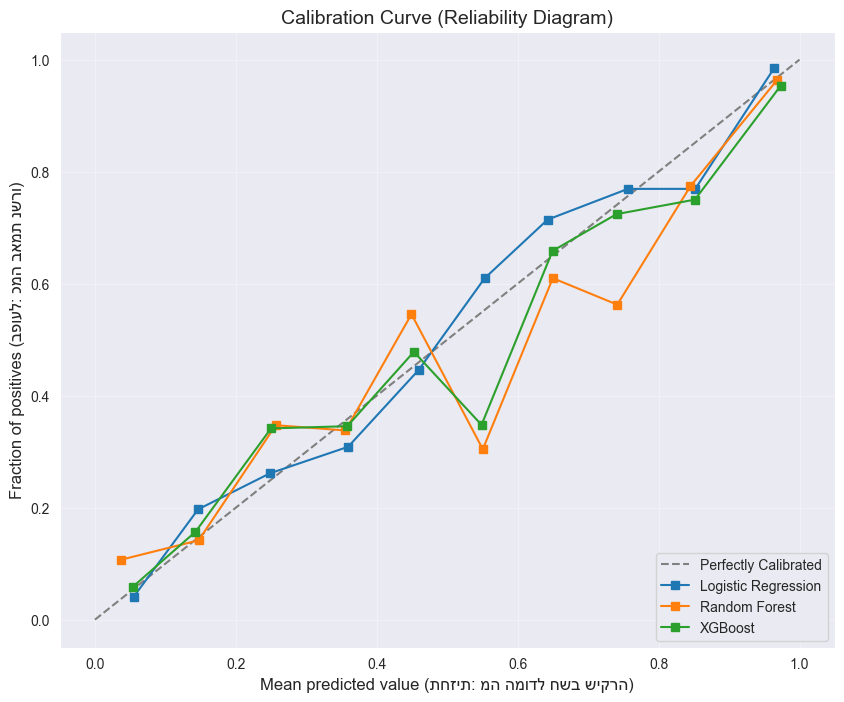

In [355]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# --- 1. הגדרת המודלים להשוואה ---
# וודא שהשמות כאן תואמים לשמות המשתנים במחברת שלך
models_to_plot = {
    "Logistic Regression": pipe_log,   # בדרך כלל הכי מכויל
    "Random Forest": pipe_rf,          # נוטה להיות בצורת S
    "XGBoost": pipe_xgb                # לרוב חזק מאוד
}

plt.figure(figsize=(10, 8))

# --- 2. ציור קו הייחוס (המודל המושלם) ---
# קו אלכסוני אפור: המטרה שלנו היא להיות כמה שיותר קרובים אליו
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

# --- 3. לולאה על כל המודלים וחישוב העקומה ---
for name, model in models_to_plot.items():
    # חישוב ההסתברויות (כמו שעשינו ב-AUC)
    if hasattr(model, "predict_proba"):
        prob_pos = model.predict_proba(X_test)[:, 1]
    else:
        # למקרה שיש מודל בלי predict_proba (נדיר בשימוש שלנו)
        continue

    # הפונקציה שמחשבת את הכיול
    # n_bins=10 אומר שאנחנו מחלקים את הסטודנטים ל-10 קבוצות לפי רמת הסיכון
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

    # הוספה לגרף
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=name)

# --- 4. עיצוב הגרף ---
plt.ylabel("Fraction of positives (בפועל: כמה באמת נשרו)", fontsize=12)
plt.xlabel("Mean predicted value (תחזית: מה המודל חשב שיקרה)", fontsize=12)
plt.title("Calibration Curve (Reliability Diagram)", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)

plt.show()